In [ ]:
### Intro to Pseudotemporal Ordering Analysis
# single cell analysis provides an extremely high resolution view of biological tissues
# But, scRNAseq is a destructive method, so studying a cell, or cell population over time is impossible
# as such, it is at times necessary to estimate the more dynamic biological processes from the snapshot 
# data scRNAseq provides. 
# The most important thing to remember (and the thinking that unlocks these styles of analysis) is that 
# samples include a heterogenous mixture of cells in the tissue of interest (due to asynchronous nature 
# of biological processes). From a sample then, a number of developmental processes can be observed and
# the lineage of a cell type can be reconstructed through the process of trajectory inference. 
# This is done by ordering cellular states according to the developmental process, states are then 
# aligned along the developmental direction by mapping discrete annotations to a continous time domain 
# (pseudotime)
# Pseudotimes rank cells relatvie to each other according to their respective stage in the developmental
# process, with less mature (undifferentiated, young,etc) cells getting small values while mature 
# (fully differentiated, old, etc) cells get large values. using bone marrow as an example, hematopoietic
# stem cells receive low psuedotime while erythroid cells receive a high psuedotime. Assignments are 
# based on the transcriptomic profile of a cell and needs a root or seed cell where the process starts.


In [1]:
### Pseudotime (PT) construction
# pt construction generally follows the same workflow with splits between methodologies
# 1. project high-dimension data onto a low dimension representation (dimensional reduction)
# 2a. Clustering, then connections between clusters identified (hierarchically). 
# 2b. Graph like representation on the low dim. representation, then clusters are defined on the graph 
# (a leiden clustering like approach to clustering) 
# 2c. Manifold-learning first cluster, then connect clusters based on low dimension curves that connect 
# high dimension clusters
# 2d. probabilistic methods that assign transition probabilities to cell pairs. Transition probabilities 
# define a random process that is used to define a PT measure. Ex: a modeling trajectories as Markov chains

# These methods are more or less approrpiate for certain kinds of biological questions and research should
# be done to insure that the PT method aligns with the natre of the biological process (is it branching? 
# cyclic?) similarly, attention needs to be paid to ensure that cells that are part of separate 
# trajectories do not 'cross contaminate' 
# https://www.sciencedirect.com/science/article/pii/S2452310021000299?via%3Dihub for a review of the PT
# literature

In [10]:
# using adult human bone marrow I will show the construction of a pseudotime 
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
adata = sc.read(filename='bone_marrow.h5ad', backup_url="https://figshare.com/ndownloader/files/35826944")
adata

AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

In [11]:
#next pre-process data prior to PT construction.
sc.pp.filter_genes(adata, min_counts=20) # remove genes expressed in fewer than 20 cells
sc.pp.normalize_total(adata) # normalize cells to a total count of genes, so that each cell has the same total count
sc.pp.log1p(adata) # log transform counts to reduce outliers impact on future steps
sc.pp.highly_variable_genes(adata) # identify highly variable genes, will be the focus of future steps

sc.tl.pca(adata) # principal component analysis of dataset


/opt/miniconda3/envs/test_jupyter_env/lib/python3.9/site-packages/pandas/core/util/hashing.py:357: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding
/opt/miniconda3/envs/test_jupyter_env/lib/python3.9/site-packages/pandas/core/util/hashing.py:357: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding


<Axes: >

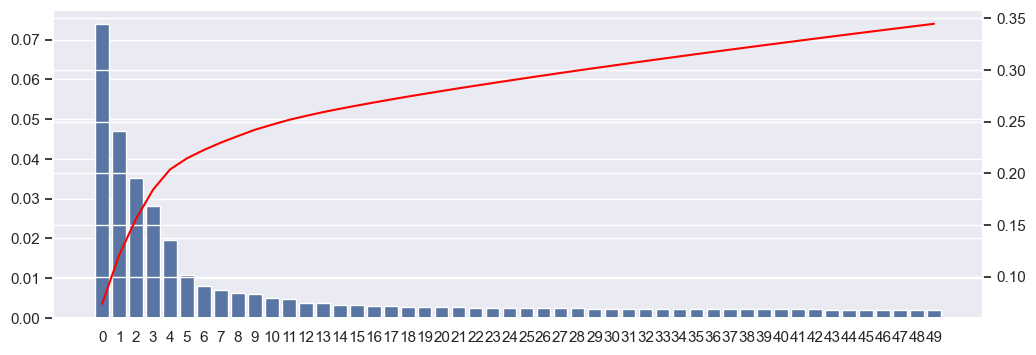

In [12]:
#visualize explained variance to pick number of PCs for neighbor analysis
tmp = adata.uns['pca']['variance_ratio']
sns.set(rc={'figure.figsize':(12, 4)})
fig, ax = plt.subplots()
sns.barplot(tmp, ax=ax)
ax2 = ax.twinx()
sns.lineplot(np.cumsum(tmp), ax=ax2, color="red")

In [ ]:
sc.pp.neighbors(adata, n_pcs=10) # neighbor based clustering using first 10 pcs
